In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
import pickle

In [4]:
# from google.colab import drive
# drive.mount('/content/drive/')

Mounted at /content/drive/


Функция для отрисовки важности фичей.

In [3]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.savefig('Catboost_feature_importance.png', bbox_inches='tight')

Данный ноутбук содержит финальные версии модели Catboost.  
Наилучшая модель включила в себя:
 - признаки:
   - `text_str` - лемматизированный текст новостей
   - `title_lemmas` - лемматизированные заголовки
   - `date_enc` - закодированная дата (_подробнее о кодировке см. ML_model_catboost.ipybn_ )
   - `year` - год
   - `season` - время загода (_подробнее о кодировке см. ML_model_catboost.ipybn_ )
   - `day_of_week` - день недели (_подробнее о кодировке см. ML_model_catboost.ipybn_ )  
 - оптимальные гиперпараметры:
   - `n_estimators=1600` - кол-во деревьев
   - `depth=9` - глубина деревьев
   - learning rate подбирался самим алгоритмом катбуста


При построении моделей обнаружилась следующая проблема: 
> Выявление лучших признаков и подбор гиперпараметров производился только на 200к текстов. И логично, что это требует совершенно дрeubt мощности, чем построение модели на 1млн текстов. Catboost строился на gpu (коллаб).  
> При запуске модели на всех признаках выделенной 12ГБ памяти не хватило. 

В связи с этим было разработано 2 пути решения данной проблемы:
 1. Запустить модель локально на cpu (в связи отсутствия локального gpu).
 2. Запустить модель на gpu (коллаб), но взять меньший объем обучающей выборки  

**Вариант 1**
Как известно Catboost на cpu обучается в разы дольше, чем на gpu. Когда он был запущен на cpu с заранее подобранными оптимальными гиперпараметрами, то примерное время рассчета составляло 4 суток. В связи с этим было решено намеренно ухудшить гиперпараметры: кол-во деревьев - 1000, максимальная глубина дерева - 5. Размер выбор ки составил 90% от исходных данных.

**Вариант 2**
В этом случае гиперпараметры были оставлены оптимальными, однако обучающая выборка была сокращена наполовину. Максимальный размер обучающей выбоки составил 55% от исходных данных.

Таким образом, провелся следующий эксперимент: что в итоге будет критичнее для качества модели - уменьшение выборки в 2 раза или ухудшение гиперпараметров.

___

Сравнение всех моделей можно найти в конце ноутбука.

## Модели: catboost на 90% выброки (cpu)

In [4]:
#df = pd.read_csv('/content/drive/MyDrive/lenta_mystem_lemmas_str_largecol.csv')
df = pd.read_csv('lenta_mystem_lemmas_str_largecol_v02.csv')

In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
df

,date,url,topic,tags,text_str,topic_le,title_lemmas,year,month,day,date_enc,season,day_of_week,dummy_weekday
0,1999-08-31,https://lenta.ru/news/1999/08/31/stancia_mir/,Россия,Все,становиться известно агентство ассошиэйтед пре...,20,космонавт сомневаться надежность мир,1999,8,31,0,3,1,1
1,1999-08-31,https://lenta.ru/news/1999/08/31/vzriv/,Россия,Все,зал игровой автомат третий ярус подземный комп...,20,взрыв центр москва пострадать человек,1999,8,31,0,3,1,1
2,1999-08-31,https://lenta.ru/news/1999/08/31/credit_japs/,Россия,Все,япония принимать решение размораживать кредит ...,20,япония кредитовать россия полтора миллиард доллар,1999,8,31,0,3,1,1
3,1999-08-31,https://lenta.ru/news/1999/08/31/diana/,Мир,Все,британец отмечать сегодня скорбный дата вторую...,13,британец отмечать двухлетие смерть диана,1999,8,31,0,3,1,1
4,1999-08-31,https://lenta.ru/news/1999/08/31/mvf/,Россия,Все,понедельник директор департамент внешний связь...,20,отмывать bank деньги иметь отношение мвф,1999,8,31,0,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153089,2022-11-18,https://lenta.ru/news/2022/11/18/bezhh/,Мир,Общество,беженец украина избивать город кейзер американ...,13,беженец украина избивать спор нацист,2022,11,18,8472,4,4,1
1153090,2022-11-18,https://lenta.ru/news/2022/11/18/nurmagomedov/,Спорт,Бокс и ММА,российский боец смешанный стиль мма двоюродный...,23,брат нурмагомедов называть цель выступление be...,2022,11,18,8472,4,4,1
1153091,2022-11-18,https://lenta.ru/news/2022/11/18/bioprint/,Наука и техника,Будущее,ученый израильский технологический институт ра...,16,разрабатывать технология печать ткань транспла...,2022,11,18,8472,4,4,1
1153092,2022-11-18,https://lenta.ru/news/2022/11/18/penni/,Мир,Политика,республиканец палата представитель конгресс сш...,13,республиканец конгресс потребовать проверять к...,2022,11,18,8472,4,4,1


In [7]:
df.columns

Index(['date', 'url', 'topic', 'tags', 'text_str', 'topic_le', 'title_lemmas',
       'year', 'month', 'day', 'date_enc', 'season', 'day_of_week',
       'dummy_weekday'],
      dtype='object')

In [8]:
df['topic'].value_counts().index[-6:]

Index(['Библиотека', 'Оружие', 'ЧМ-2014', 'Мотор', 'МедНовости', 'Сочи'], dtype='object')

In [9]:
names = list(df['topic'].value_counts().index[-6:])
df = df[~df['topic'].isin(names)]

In [10]:
df['topic'].value_counts()

Россия               241055
Мир                  195778
Экономика            122120
Бывший СССР           93769
Спорт                 91267
Наука и техника       75609
Культура              71765
Интернет и СМИ        64800
Из жизни              44812
Силовые структуры     43287
Путешествия           22756
Ценности              22323
Дом                   22132
Среда обитания        15607
Бизнес                 7430
Моя страна             6128
Нацпроекты             4728
69-я параллель         3356
Забота о себе          3174
Крым                    666
Культпросвет            340
Легпром                 114
Name: topic, dtype: int64

Чтобы модель долго не обучалась, будем тестировать разные фичи и подбирать гиперы только на части данных.

In [11]:
dftrain, dftest, ytrain, ytest = train_test_split(df, df['topic_le'],
                                                  test_size=0.1,
                                                  stratify=df['topic'], 
                                                  random_state=123)

In [ ]:
del df

In [ ]:
dftrain.head(2)

,date,url,topic,tags,text_str,topic_le,title_lemmas,year,month,day,date_enc,season,day_of_week,dummy_weekday
384053,2011-08-02,https://lenta.ru/news/2011/08/02/alps/,Из жизни,Все,австрийский спортсмен экстремал давид вайхенбе...,6,австрийский экстремал пересекать альпы однокол...,2011,8,2,4351,3,1,1
534812,2015-02-09,https://lenta.ru/news/2015/02/09/yarema_ostaet...,Бывший СССР,Украина,источник украинский издание вести администраци...,3,слух отставка генпрокурор украина называть тро...,2015,2,9,5638,1,0,1


In [ ]:
dftrain.shape

(1037714, 14)

In [ ]:
dftrain.columns

Index(['date', 'url', 'topic', 'tags', 'text_str', 'topic_le', 'title_lemmas',
       'year', 'month', 'day', 'date_enc', 'season', 'day_of_week',
       'dummy_weekday'],
      dtype='object')

In [ ]:
#df_train = dftrain[['text_str', 'title_lemmas', 'year', 'month', 'day']]

text_cols = ['text_str', 'title_lemmas']
cat_cols = ['year', 'day_of_week', 'season']

In [ ]:
clf = CatBoostClassifier(random_state=123, 
                         loss_function='MultiClass', 
                         eval_metric='TotalF1', 
                         #task_type='GPU',                         
                         n_estimators=1000,
                         #learning_rate=0.2,
                         depth=5)
                         #max_ctr_complexity=2)

In [ ]:
clf.fit(dftrain[['text_str', 'title_lemmas', 'date_enc', 'year', 'season', 'day_of_week']], ytrain, text_features=text_cols, cat_features=cat_cols)

Learning rate set to 0.112757
0:	learn: 0.3212657	total: 1m 56s	remaining: 1d 8h 15m 37s
1:	learn: 0.3211737	total: 3m 46s	remaining: 1d 7h 27m 5s
2:	learn: 0.3513074	total: 5m 43s	remaining: 1d 7h 41m 10s
3:	learn: 0.3854800	total: 7m 41s	remaining: 1d 7h 53m 57s
4:	learn: 0.3878916	total: 9m 38s	remaining: 1d 7h 57m 28s
5:	learn: 0.3871602	total: 11m 24s	remaining: 1d 7h 30m 10s
6:	learn: 0.3984890	total: 13m 20s	remaining: 1d 7h 32m 20s
7:	learn: 0.3990828	total: 15m 9s	remaining: 1d 7h 19m 40s
8:	learn: 0.4043867	total: 17m 7s	remaining: 1d 7h 24m 51s
9:	learn: 0.4266800	total: 19m 9s	remaining: 1d 7h 36m 20s
10:	learn: 0.4316233	total: 21m 10s	remaining: 1d 7h 43m 29s
11:	learn: 0.4448658	total: 23m 3s	remaining: 1d 7h 37m 57s
12:	learn: 0.4444200	total: 24m 52s	remaining: 1d 7h 28m 31s
13:	learn: 0.4475023	total: 26m 50s	remaining: 1d 7h 30m 15s
14:	learn: 0.4470406	total: 28m 35s	remaining: 1d 7h 17m 27s
15:	learn: 0.4642498	total: 30m 40s	remaining: 1d 7h 26m 22s
16:	learn: 0.4

131:	learn: 0.6576715	total: 4h 8m 1s	remaining: 1d 3h 10m 58s
132:	learn: 0.6584233	total: 4h 10m	remaining: 1d 3h 9m 44s
133:	learn: 0.6593855	total: 4h 12m 5s	remaining: 1d 3h 9m 13s
134:	learn: 0.6597602	total: 4h 14m 12s	remaining: 1d 3h 8m 50s
135:	learn: 0.6604298	total: 4h 16m 17s	remaining: 1d 3h 8m 14s
136:	learn: 0.6615494	total: 4h 18m 25s	remaining: 1d 3h 7m 53s
137:	learn: 0.6616163	total: 4h 20m 27s	remaining: 1d 3h 6m 56s
138:	learn: 0.6625965	total: 4h 22m 35s	remaining: 1d 3h 6m 31s
139:	learn: 0.6643853	total: 4h 24m 46s	remaining: 1d 3h 6m 27s
140:	learn: 0.6651928	total: 4h 26m 52s	remaining: 1d 3h 5m 53s
141:	learn: 0.6657217	total: 4h 28m 47s	remaining: 1d 3h 4m 8s
142:	learn: 0.6664805	total: 4h 30m 38s	remaining: 1d 3h 1m 57s
143:	learn: 0.6679992	total: 4h 32m 35s	remaining: 1d 3h 25s
144:	learn: 0.6689713	total: 4h 34m 33s	remaining: 1d 2h 58m 57s
145:	learn: 0.6696539	total: 4h 36m 26s	remaining: 1d 2h 56m 59s
146:	learn: 0.6705113	total: 4h 38m 19s	remainin

262:	learn: 0.7231779	total: 8h 8m 30s	remaining: 22h 48m 57s
263:	learn: 0.7233467	total: 8h 10m 9s	remaining: 22h 46m 29s
264:	learn: 0.7238737	total: 8h 11m 57s	remaining: 22h 44m 29s
265:	learn: 0.7243869	total: 8h 13m 44s	remaining: 22h 42m 26s
266:	learn: 0.7247446	total: 8h 15m 31s	remaining: 22h 40m 22s
267:	learn: 0.7254354	total: 8h 17m 27s	remaining: 22h 38m 43s
268:	learn: 0.7258447	total: 8h 19m 13s	remaining: 22h 36m 37s
269:	learn: 0.7264273	total: 8h 21m 10s	remaining: 22h 35m 1s
270:	learn: 0.7267478	total: 8h 23m	remaining: 22h 33m 7s
271:	learn: 0.7268911	total: 8h 24m 44s	remaining: 22h 30m 55s
272:	learn: 0.7274899	total: 8h 26m 31s	remaining: 22h 28m 53s
273:	learn: 0.7275773	total: 8h 28m 11s	remaining: 22h 26m 30s
274:	learn: 0.7278579	total: 8h 29m 59s	remaining: 22h 24m 30s
275:	learn: 0.7279051	total: 8h 31m 36s	remaining: 22h 22m 2s
276:	learn: 0.7281211	total: 8h 33m 23s	remaining: 22h 20m
277:	learn: 0.7284652	total: 8h 35m 14s	remaining: 22h 18m 8s
278:	l

394:	learn: 0.7565781	total: 12h 16m 36s	remaining: 18h 48m 13s
395:	learn: 0.7567304	total: 12h 18m 32s	remaining: 18h 46m 27s
396:	learn: 0.7569015	total: 12h 20m 25s	remaining: 18h 44m 37s
397:	learn: 0.7570303	total: 12h 22m 17s	remaining: 18h 42m 46s
398:	learn: 0.7570280	total: 12h 24m 4s	remaining: 18h 40m 46s
399:	learn: 0.7573235	total: 12h 25m 59s	remaining: 18h 38m 59s
400:	learn: 0.7574648	total: 12h 27m 53s	remaining: 18h 37m 10s
401:	learn: 0.7576678	total: 12h 29m 47s	remaining: 18h 35m 21s
402:	learn: 0.7577492	total: 12h 31m 32s	remaining: 18h 33m 20s
403:	learn: 0.7578549	total: 12h 33m 16s	remaining: 18h 31m 15s
404:	learn: 0.7581285	total: 12h 35m 13s	remaining: 18h 29m 31s
405:	learn: 0.7583116	total: 12h 37m 6s	remaining: 18h 27m 41s
406:	learn: 0.7584463	total: 12h 38m 57s	remaining: 18h 25m 48s
407:	learn: 0.7585743	total: 12h 40m 52s	remaining: 18h 24m
408:	learn: 0.7589425	total: 12h 42m 47s	remaining: 18h 22m 13s
409:	learn: 0.7592111	total: 12h 44m 41s	remai

524:	learn: 0.7756469	total: 16h 20m 13s	remaining: 14h 46m 51s
525:	learn: 0.7756934	total: 16h 22m	remaining: 14h 44m 55s
526:	learn: 0.7758395	total: 16h 23m 58s	remaining: 14h 43m 9s
527:	learn: 0.7759411	total: 16h 25m 53s	remaining: 14h 41m 20s
528:	learn: 0.7760564	total: 16h 27m 49s	remaining: 14h 39m 31s
529:	learn: 0.7762680	total: 16h 29m 45s	remaining: 14h 37m 42s
530:	learn: 0.7764392	total: 16h 31m 32s	remaining: 14h 35m 45s
531:	learn: 0.7765733	total: 16h 33m 25s	remaining: 14h 33m 55s
532:	learn: 0.7766416	total: 16h 35m 19s	remaining: 14h 32m 4s
533:	learn: 0.7767444	total: 16h 37m 13s	remaining: 14h 30m 14s
534:	learn: 0.7769633	total: 16h 39m 12s	remaining: 14h 28m 28s
535:	learn: 0.7770278	total: 16h 41m 5s	remaining: 14h 26m 37s
536:	learn: 0.7770879	total: 16h 42m 57s	remaining: 14h 24m 44s
537:	learn: 0.7772158	total: 16h 44m 54s	remaining: 14h 22m 56s
538:	learn: 0.7773430	total: 16h 46m 48s	remaining: 14h 21m 6s
539:	learn: 0.7773513	total: 16h 48m 34s	remaini

654:	learn: 0.7888139	total: 20h 20m 46s	remaining: 10h 43m
655:	learn: 0.7889702	total: 20h 22m 42s	remaining: 10h 41m 10s
656:	learn: 0.7890018	total: 20h 24m 25s	remaining: 10h 39m 14s
657:	learn: 0.7890818	total: 20h 26m 17s	remaining: 10h 37m 22s
658:	learn: 0.7890740	total: 20h 27m 58s	remaining: 10h 35m 24s
659:	learn: 0.7891191	total: 20h 29m 48s	remaining: 10h 33m 32s
660:	learn: 0.7891666	total: 20h 31m 32s	remaining: 10h 31m 36s
661:	learn: 0.7893052	total: 20h 33m 20s	remaining: 10h 29m 42s
662:	learn: 0.7893429	total: 20h 35m 3s	remaining: 10h 27m 46s
663:	learn: 0.7894474	total: 20h 36m 51s	remaining: 10h 25m 53s
664:	learn: 0.7895960	total: 20h 38m 42s	remaining: 10h 24m
665:	learn: 0.7896440	total: 20h 40m 31s	remaining: 10h 22m 7s
666:	learn: 0.7897783	total: 20h 42m 21s	remaining: 10h 20m 15s
667:	learn: 0.7898078	total: 20h 44m 6s	remaining: 10h 18m 19s
668:	learn: 0.7899618	total: 20h 45m 54s	remaining: 10h 16m 26s
669:	learn: 0.7900575	total: 20h 47m 44s	remaining:

786:	learn: 0.7983866	total: 1d 23m 38s	remaining: 6h 36m 7s
787:	learn: 0.7985583	total: 1d 25m 32s	remaining: 6h 34m 17s
788:	learn: 0.7985686	total: 1d 27m 23s	remaining: 6h 32m 25s
789:	learn: 0.7986517	total: 1d 29m 20s	remaining: 6h 30m 35s
790:	learn: 0.7987267	total: 1d 31m 15s	remaining: 6h 28m 44s
791:	learn: 0.7988330	total: 1d 33m 6s	remaining: 6h 26m 52s
792:	learn: 0.7989059	total: 1d 35m	remaining: 6h 25m 1s
793:	learn: 0.7989498	total: 1d 36m 53s	remaining: 6h 23m 10s
794:	learn: 0.7990009	total: 1d 38m 46s	remaining: 6h 21m 19s
795:	learn: 0.7991380	total: 1d 40m 36s	remaining: 6h 19m 27s
796:	learn: 0.7991887	total: 1d 42m 29s	remaining: 6h 17m 35s
797:	learn: 0.7992148	total: 1d 44m 19s	remaining: 6h 15m 43s
798:	learn: 0.7992655	total: 1d 46m 8s	remaining: 6h 13m 51s
799:	learn: 0.7993235	total: 1d 47m 54s	remaining: 6h 11m 58s
800:	learn: 0.7993611	total: 1d 49m 43s	remaining: 6h 10m 6s
801:	learn: 0.7994946	total: 1d 51m 35s	remaining: 6h 8m 14s
802:	learn: 0.7995

915:	learn: 0.8060627	total: 1d 4h 25m 34s	remaining: 2h 36m 24s
916:	learn: 0.8062024	total: 1d 4h 27m 34s	remaining: 2h 34m 33s
917:	learn: 0.8062188	total: 1d 4h 29m 26s	remaining: 2h 32m 41s
918:	learn: 0.8063223	total: 1d 4h 31m 22s	remaining: 2h 30m 50s
919:	learn: 0.8063288	total: 1d 4h 33m 7s	remaining: 2h 28m 58s
920:	learn: 0.8064066	total: 1d 4h 35m 3s	remaining: 2h 27m 6s
921:	learn: 0.8064406	total: 1d 4h 36m 55s	remaining: 2h 25m 14s
922:	learn: 0.8064614	total: 1d 4h 38m 42s	remaining: 2h 23m 22s
923:	learn: 0.8065514	total: 1d 4h 40m 33s	remaining: 2h 21m 31s
924:	learn: 0.8066476	total: 1d 4h 42m 27s	remaining: 2h 19m 39s
925:	learn: 0.8066918	total: 1d 4h 44m 20s	remaining: 2h 17m 47s
926:	learn: 0.8067868	total: 1d 4h 46m 17s	remaining: 2h 15m 56s
927:	learn: 0.8068733	total: 1d 4h 48m 11s	remaining: 2h 14m 5s
928:	learn: 0.8069374	total: 1d 4h 50m 3s	remaining: 2h 12m 13s
929:	learn: 0.8070357	total: 1d 4h 51m 58s	remaining: 2h 10m 21s
930:	learn: 0.8070672	total: 1

In [ ]:
pkl_filename = "pickle_model_catboost_final.pkl" 
with open(pkl_filename, 'wb') as file: 
    pickle.dump(clf, file) 

### Результаты

In [12]:
pkl_filename = "pickle_model_catboost_final.pkl"
with open(pkl_filename, 'rb') as file:
    clf = pickle.load(file)

In [13]:
dict_topic = dict(zip(dftrain.topic, dftrain.topic_le))
dict_topic = dict(sorted(dict_topic.items(), key=lambda item: item[1]))

# Catboost 1000 деревьев + ['text_str', 'title_lemmas', 'title', 'year', 'month', 'day']
y_pred1 = clf.predict(dftest[['text_str', 'title_lemmas', 'date_enc', 'year', 'season', 'day_of_week']])
print(classification_report(ytest, y_pred1, target_names=dict_topic))
f1_score(ytest, y_pred1, average='micro')

                   precision    recall  f1-score   support

   69-я параллель       0.82      0.24      0.37       336
           Бизнес       0.70      0.65      0.67       743
      Бывший СССР       0.82      0.84      0.83      9377
              Дом       0.86      0.74      0.80      2213
    Забота о себе       0.79      0.83      0.81       317
         Из жизни       0.74      0.60      0.66      4481
   Интернет и СМИ       0.73      0.63      0.68      6480
             Крым       0.75      0.36      0.48        67
    Культпросвет        0.62      0.15      0.24        34
         Культура       0.83      0.84      0.84      7176
          Легпром       0.50      0.36      0.42        11
              Мир       0.79      0.84      0.81     19578
       Моя страна       0.81      0.69      0.75       613
  Наука и техника       0.84      0.84      0.84      7561
       Нацпроекты       0.88      0.81      0.84       473
      Путешествия       0.84      0.75      0.79      2

0.8085028880678565

In [14]:
f1 = f1_score(ytest, y_pred1, average='micro')
print(f'F1-score by Catboost (1000 trees, trees depth - 5) is {f1}')

F1-score by Catboost (1000 trees, trees depth - 5) is 0.8085028880678565


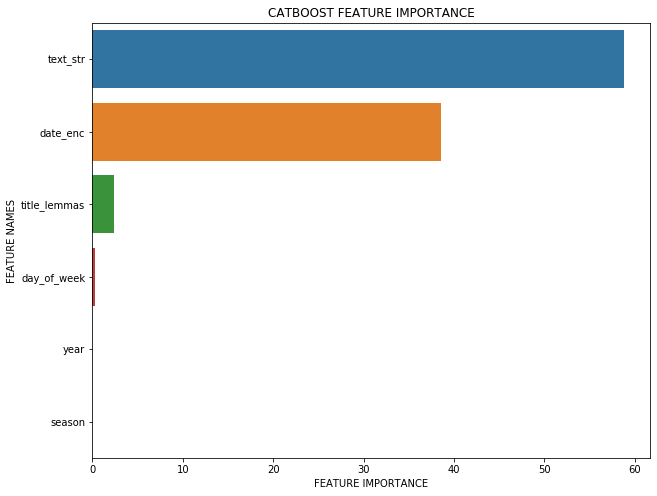

In [15]:
#plot the catboost result
plot_feature_importance(clf.get_feature_importance(),
                        ['text_str', 'title_lemmas', 'date_enc', 'year', 'season', 'day_of_week'],
                        'CATBOOST ')

In [18]:
name_col = ['F1 score', 'train size', 'predict size', 'num of trees', 'depth', 'text_str', 
            'title_lemmas', 'date_enc', 'year', 'season', 'day_of_week']
data_ct1000_5_90_cpu = [f1, '90%', '10%', 1000, 5, *list(clf.get_feature_importance())]

metrics = pd.DataFrame(columns = name_col)
metrics.loc[len(metrics)] = data_ct1000_5_90_cpu
metrics.index = ['Catboost cpu']
metrics = metrics.astype({'num of trees' :'int', 'depth': 'int'})
metrics

,F1 score,train size,predict size,num of trees,depth,text_str,title_lemmas,date_enc,year,season,day_of_week
Catboost cpu,0.808503,90%,10%,1000,5,58.817622,2.362638,38.53064,0.0,0.0,0.2891


## Модели: catboost на 55% выброки (gpu)

In [4]:
df = pd.read_csv('/content/drive/MyDrive/df_for_catboost.csv')

In [5]:
df['topic'].value_counts()

Россия               241055
Мир                  195778
Экономика            122120
Бывший СССР           93769
Спорт                 91267
Наука и техника       75609
Культура              71765
Интернет и СМИ        64800
Из жизни              44812
Силовые структуры     43287
Путешествия           22756
Ценности              22323
Дом                   22132
Среда обитания        15607
Бизнес                 7430
Моя страна             6128
Нацпроекты             4728
69-я параллель         3356
Забота о себе          3174
Крым                    666
Культпросвет            340
Легпром                 114
Name: topic, dtype: int64

In [6]:
dftrain, dftest, ytrain, ytest = train_test_split(df, df['topic_le'],
                                                  test_size=0.45,
                                                  stratify=df['topic'], 
                                                  random_state=123)

In [7]:
del df

In [8]:
dftrain.head(2)

,text_str,title_lemmas,date_enc,year,season,day_of_week,topic,topic_le
1000019,страна запад пообещать оказывать украина помощ...,запад пообещать украина помощь случай наступле...,8111,2021,4,0,Бывший СССР,3
439049,президент аргентина кристина фернандес киршнер...,арест аргентинский корабль стоить место команд...,4790,2012,4,1,Мир,13


In [9]:
dftrain.shape

(634158, 8)

In [10]:
text_cols = ['text_str', 'title_lemmas']
cat_cols = ['year', 'day_of_week', 'season']

In [11]:
clf = CatBoostClassifier(random_state=123, 
                         loss_function='MultiClass', 
                         eval_metric='TotalF1', 
                         task_type='GPU',                         
                         n_estimators=1600,
                         #learning_rate=0.2,
                         depth=9)
                         #max_ctr_complexity=2)

In [16]:
clf.fit(dftrain[['text_str', 'title_lemmas', 'date_enc', 'year', 'season', 'day_of_week']],
        ytrain,
        text_features=text_cols,
        cat_features=cat_cols)

Learning rate set to 0.163644
0:	learn: 0.6828084	total: 743ms	remaining: 19m 48s
1:	learn: 0.7388675	total: 1.38s	remaining: 18m 18s
2:	learn: 0.7439128	total: 1.97s	remaining: 17m 29s
3:	learn: 0.7473022	total: 2.64s	remaining: 17m 33s
4:	learn: 0.7567409	total: 3.47s	remaining: 18m 26s
5:	learn: 0.7584201	total: 4.17s	remaining: 18m 28s
6:	learn: 0.7645669	total: 4.98s	remaining: 18m 53s
7:	learn: 0.7664445	total: 5.67s	remaining: 18m 49s
8:	learn: 0.7719855	total: 6.45s	remaining: 19m
9:	learn: 0.7775851	total: 7.18s	remaining: 19m 1s
10:	learn: 0.7791439	total: 7.97s	remaining: 19m 12s
11:	learn: 0.7811643	total: 8.52s	remaining: 18m 47s
12:	learn: 0.7821109	total: 9.26s	remaining: 18m 50s
13:	learn: 0.7854635	total: 9.93s	remaining: 18m 45s
14:	learn: 0.7899041	total: 10.4s	remaining: 18m 18s
15:	learn: 0.7930633	total: 11s	remaining: 18m 11s
16:	learn: 0.7952334	total: 11.6s	remaining: 18m 2s
17:	learn: 0.7963341	total: 12.2s	remaining: 17m 53s
18:	learn: 0.7977463	total: 12.8s	

In [17]:
pkl_filename = "pickle_model_catboost_final_gpu55%.pkl" 
with open(pkl_filename, 'wb') as file: 
    pickle.dump(clf, file)

In [ ]:
clf = CatBoostClassifier(random_state=123, 
                         loss_function='MultiClass', 
                         eval_metric='TotalF1', 
                         task_type='GPU',                         
                         n_estimators=2000,
                         #learning_rate=0.2,
                         depth=9)
                         #max_ctr_complexity=2)

In [12]:
clf.fit(dftrain[['text_str', 'title_lemmas', 'date_enc', 'year', 'season', 'day_of_week']],
        ytrain,
        text_features=text_cols,
        cat_features=cat_cols)

Learning rate set to 0.135886
0:	learn: 0.6828084	total: 775ms	remaining: 25m 49s
1:	learn: 0.7018628	total: 1.4s	remaining: 23m 18s
2:	learn: 0.7407345	total: 2.12s	remaining: 23m 32s
3:	learn: 0.7473666	total: 2.73s	remaining: 22m 44s
4:	learn: 0.7483408	total: 3.42s	remaining: 22m 43s
5:	learn: 0.7548212	total: 4.17s	remaining: 23m 5s
6:	learn: 0.7565593	total: 4.82s	remaining: 22m 51s
7:	learn: 0.7628628	total: 5.61s	remaining: 23m 16s
8:	learn: 0.7648572	total: 6.49s	remaining: 23m 56s
9:	learn: 0.7664135	total: 7.25s	remaining: 24m 3s
10:	learn: 0.7679376	total: 8.05s	remaining: 24m 15s
11:	learn: 0.7739604	total: 8.75s	remaining: 24m 9s
12:	learn: 0.7747487	total: 9.53s	remaining: 24m 15s
13:	learn: 0.7800669	total: 10.3s	remaining: 24m 14s
14:	learn: 0.7811530	total: 10.9s	remaining: 24m 7s
15:	learn: 0.7820685	total: 11.6s	remaining: 24m
16:	learn: 0.7841392	total: 12.2s	remaining: 23m 40s
17:	learn: 0.7853740	total: 12.9s	remaining: 23m 42s
18:	learn: 0.7896243	total: 13.4s	r

In [13]:
pkl_filename = "pickle_model_catboost_final_gpu55%_2000trees.pkl" 
with open(pkl_filename, 'wb') as file: 
    pickle.dump(clf, file)

### Результаты

#### Модель Catboost 1600 деревьев, глубина дерева = 9, обученная на 55% выборки

In [19]:
pkl_filename = "pickle_model_catboost_final_gpu55%.pkl"
with open(pkl_filename, 'rb') as file:
    clf = pickle.load(file)

##### Test - 45%

In [20]:
dftrain, dftest, ytrain, ytest = train_test_split(df, df['topic_le'],
                                                  test_size=0.45,
                                                  stratify=df['topic'], 
                                                  random_state=123)
dftest.shape

(518858, 14)

In [21]:
dict_topic = dict(zip(dftrain.topic, dftrain.topic_le))
dict_topic = dict(sorted(dict_topic.items(), key=lambda item: item[1]))

# Catboost 1600 деревьев + ['text_str', 'title_lemmas', 'title', 'year', 'month', 'day']
y_pred1 = clf.predict(dftest[['text_str', 'title_lemmas', 'date_enc', 'year', 'season', 'day_of_week']])
print(classification_report(ytest, y_pred1, target_names=dict_topic))
f1_score(ytest, y_pred1, average='micro')

                   precision    recall  f1-score   support

   69-я параллель       0.77      0.76      0.77      1510
           Бизнес       0.76      0.78      0.77      3344
      Бывший СССР       0.88      0.91      0.90     42196
              Дом       0.89      0.87      0.88      9960
    Забота о себе       0.87      0.92      0.89      1428
         Из жизни       0.80      0.76      0.78     20166
   Интернет и СМИ       0.82      0.81      0.81     29160
             Крым       0.81      0.52      0.63       300
    Культпросвет        0.65      0.28      0.39       153
         Культура       0.89      0.92      0.91     32294
          Легпром       0.78      0.27      0.41        51
              Мир       0.87      0.88      0.87     88100
       Моя страна       0.90      0.92      0.91      2758
  Наука и техника       0.91      0.90      0.91     34024
       Нацпроекты       0.93      0.94      0.93      2128
      Путешествия       0.88      0.89      0.89     10

0.8795238774385284

F1-score by Catboost (1600 trees, trees depth - 9) is 0.8795238774385284


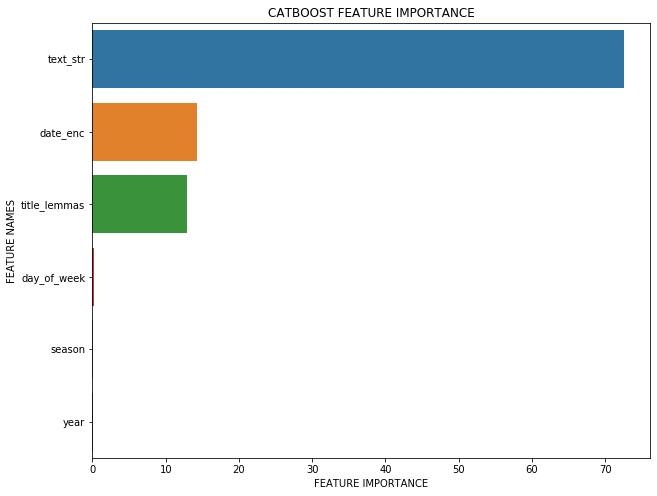

In [22]:
f1 = f1_score(ytest, y_pred1, average='micro')
print(f'F1-score by Catboost (1600 trees, trees depth - 9) is {f1}')

#plot the catboost result
plot_feature_importance(clf.get_feature_importance(),
                        ['text_str', 'title_lemmas', 'date_enc', 'year', 'season', 'day_of_week'],
                        'CATBOOST ')

In [24]:
data_ct1600_9_55_gpu = [f1,'55%', '45%', 1600, 9, *list(clf.get_feature_importance())]

metrics.loc[len(metrics)] = data_ct1600_9_55_gpu
metrics.index = ['Catboost cpu', 'Catboost gpu v01']

In [25]:
metrics

,F1 score,train size,predict size,num of trees,depth,text_str,title_lemmas,date_enc,year,season,day_of_week
Catboost cpu,0.808503,90%,10%,1000,5,58.817622,2.362638,38.530640,0.000000,0.000000,0.289100
Catboost cpu v01,0.879524,55%,45%,1600,9,72.559684,12.846796,14.215693,0.026728,0.113239,0.237861


##### Test - 10%

In [26]:
dftrain, dftest, ytrain, ytest = train_test_split(df, df['topic_le'],
                                                  test_size=0.1,
                                                  stratify=df['topic'], 
                                                  random_state=123)

dftest.shape

(115302, 14)

In [27]:
dict_topic = dict(zip(dftrain.topic, dftrain.topic_le))
dict_topic = dict(sorted(dict_topic.items(), key=lambda item: item[1]))

# Catboost 1600 деревьев + ['text_str', 'title_lemmas', 'title', 'year', 'month', 'day']
y_pred1 = clf.predict(dftest[['text_str', 'title_lemmas', 'date_enc', 'year', 'season', 'day_of_week']])
print(classification_report(ytest, y_pred1, target_names=dict_topic))
f1_score(ytest, y_pred1, average='micro')

                   precision    recall  f1-score   support

   69-я параллель       0.80      0.73      0.76       336
           Бизнес       0.74      0.78      0.76       743
      Бывший СССР       0.88      0.91      0.89      9377
              Дом       0.89      0.87      0.88      2213
    Забота о себе       0.88      0.93      0.90       317
         Из жизни       0.79      0.76      0.78      4481
   Интернет и СМИ       0.81      0.81      0.81      6480
             Крым       0.82      0.42      0.55        67
    Культпросвет        0.56      0.15      0.23        34
         Культура       0.89      0.92      0.91      7176
          Легпром       0.75      0.27      0.40        11
              Мир       0.87      0.87      0.87     19578
       Моя страна       0.92      0.92      0.92       613
  Наука и техника       0.91      0.90      0.90      7561
       Нацпроекты       0.93      0.95      0.94       473
      Путешествия       0.88      0.89      0.89      2

0.8791781582279579

F1-score by Catboost (1600 trees, trees depth - 9) is 0.8791781582279579


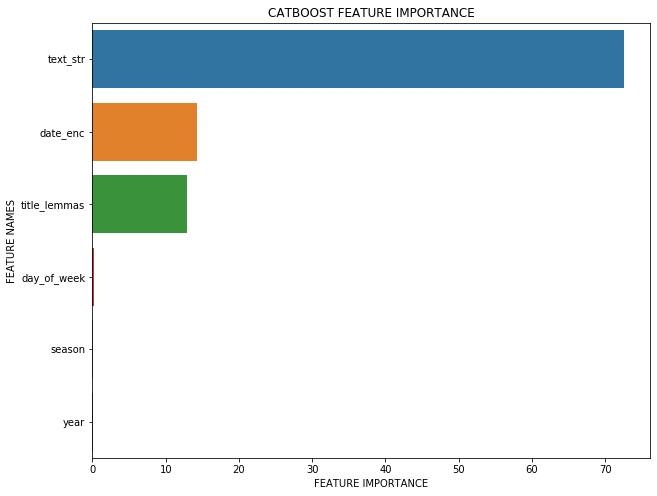

In [28]:
f1 = f1_score(ytest, y_pred1, average='micro')
print(f'F1-score by Catboost (1600 trees, trees depth - 9) is {f1}')

#plot the catboost result
plot_feature_importance(clf.get_feature_importance(),
                        ['text_str', 'title_lemmas', 'date_enc', 'year', 'season', 'day_of_week'],
                        'CATBOOST ')

In [29]:
data_ct1600_9_55_gpu = [f1, '55%', '10%', 1600, 9, *list(clf.get_feature_importance())]

metrics.loc[len(metrics)] = data_ct1600_9_55_gpu
metrics.index = ['Catboost cpu', 'Catboost gpu v01', 'Catboost gpu v01']
metrics

,F1 score,train size,predict size,num of trees,depth,text_str,title_lemmas,date_enc,year,season,day_of_week
Catboost cpu,0.808503,90%,10%,1000,5,58.817622,2.362638,38.530640,0.000000,0.000000,0.289100
Catboost gpu v01,0.879524,55%,45%,1600,9,72.559684,12.846796,14.215693,0.026728,0.113239,0.237861
Catboost gpu v01,0.879178,55%,10%,1600,9,72.559684,12.846796,14.215693,0.026728,0.113239,0.237861


#### Модель Catboost 2000 деревьев, глубина дерева = 9, обученная на 55% выборки

##### Test - 45%

In [30]:
pkl_filename = "pickle_model_catboost_final_gpu55%_2000trees.pkl"
with open(pkl_filename, 'rb') as file:
    clf = pickle.load(file)

In [31]:
dftrain, dftest, ytrain, ytest = train_test_split(df, df['topic_le'],
                                                  test_size=0.45,
                                                  stratify=df['topic'], 
                                                  random_state=123)

dftest.shape

(518858, 14)

In [32]:
dict_topic = dict(zip(dftrain.topic, dftrain.topic_le))
dict_topic = dict(sorted(dict_topic.items(), key=lambda item: item[1]))

# Catboost 1600 деревьев + ['text_str', 'title_lemmas', 'title', 'year', 'month', 'day']
y_pred1 = clf.predict(dftest[['text_str', 'title_lemmas', 'date_enc', 'year', 'season', 'day_of_week']])
print(classification_report(ytest, y_pred1, target_names=dict_topic))
f1_score(ytest, y_pred1, average='micro')

                   precision    recall  f1-score   support

   69-я параллель       0.78      0.78      0.78      1510
           Бизнес       0.76      0.78      0.77      3344
      Бывший СССР       0.88      0.91      0.90     42196
              Дом       0.89      0.88      0.88      9960
    Забота о себе       0.87      0.93      0.90      1428
         Из жизни       0.80      0.76      0.78     20166
   Интернет и СМИ       0.82      0.81      0.81     29160
             Крым       0.82      0.54      0.65       300
    Культпросвет        0.64      0.28      0.39       153
         Культура       0.89      0.92      0.91     32294
          Легпром       0.82      0.18      0.29        51
              Мир       0.87      0.88      0.87     88100
       Моя страна       0.91      0.92      0.91      2758
  Наука и техника       0.91      0.90      0.91     34024
       Нацпроекты       0.93      0.94      0.94      2128
      Путешествия       0.88      0.89      0.89     10

0.8805318603548562

F1-score by Catboost (2000 trees, trees depth - 9) is 0.8805318603548562


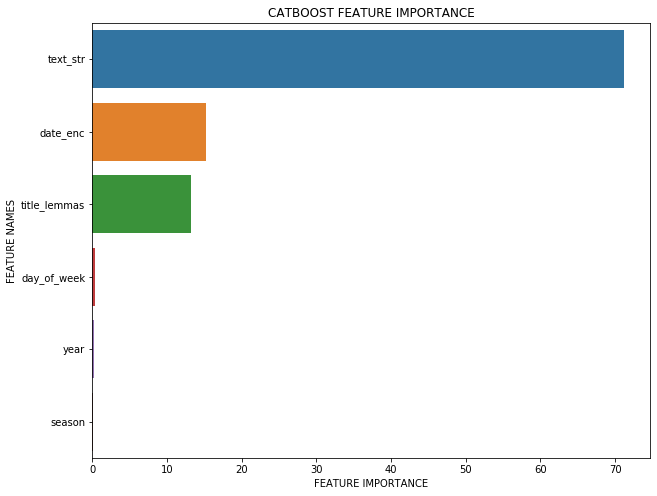

In [33]:
f1 = f1_score(ytest, y_pred1, average='micro')
print(f'F1-score by Catboost (2000 trees, trees depth - 9) is {f1}')

#plot the catboost result
plot_feature_importance(clf.get_feature_importance(),
                        ['text_str', 'title_lemmas', 'date_enc', 'year', 'season', 'day_of_week'],
                        'CATBOOST ')

In [34]:
data_ct2000_9_55_gpu = [f1, '55%', '45%', 2000, 9, *list(clf.get_feature_importance())]

metrics.loc[len(metrics)] = data_ct2000_9_55_gpu
metrics.index = ['Catboost cpu', 'Catboost gpu v01', 'Catboost gpu v01', 'Catboost gpu v02']
metrics

,F1 score,train size,predict size,num of trees,depth,text_str,title_lemmas,date_enc,year,season,day_of_week
Catboost cpu,0.808503,90%,10%,1000,5,58.817622,2.362638,38.530640,0.000000,0.000000,0.289100
Catboost cpu v01,0.879524,55%,45%,1600,9,72.559684,12.846796,14.215693,0.026728,0.113239,0.237861
Catboost cpu v01,0.879178,55%,10%,1600,9,72.559684,12.846796,14.215693,0.026728,0.113239,0.237861
Catboost cpu v02,0.880532,55%,45%,2000,9,71.184946,13.146714,15.146007,0.146486,0.098189,0.277657


#### Модель Catboost 1600 деревьев, глубина дерева = 9, обученная на 50% выборки

##### Test - 50%

In [35]:
pkl_filename = "pickle_model_catboost_final_gpu50%.pkl"
with open(pkl_filename, 'rb') as file:
    clf = pickle.load(file)

In [36]:
dftrain, dftest, ytrain, ytest = train_test_split(df, df['topic_le'],
                                                  test_size=0.5,
                                                  stratify=df['topic'], 
                                                  random_state=123)

dftest.shape

(576508, 14)

In [37]:
dict_topic = dict(zip(dftrain.topic, dftrain.topic_le))
dict_topic = dict(sorted(dict_topic.items(), key=lambda item: item[1]))

# Catboost 1600 деревьев + ['text_str', 'title_lemmas', 'title', 'year', 'month', 'day']
y_pred1 = clf.predict(dftest[['text_str', 'title_lemmas', 'date_enc', 'year', 'season', 'day_of_week']])
print(classification_report(ytest, y_pred1, target_names=dict_topic))
f1_score(ytest, y_pred1, average='micro')

                   precision    recall  f1-score   support

   69-я параллель       0.74      0.79      0.76      1678
           Бизнес       0.74      0.79      0.76      3715
      Бывший СССР       0.89      0.90      0.89     46884
              Дом       0.88      0.87      0.88     11066
    Забота о себе       0.86      0.93      0.89      1587
         Из жизни       0.79      0.76      0.78     22406
   Интернет и СМИ       0.81      0.81      0.81     32400
             Крым       0.81      0.48      0.61       333
    Культпросвет        0.70      0.31      0.43       170
         Культура       0.89      0.92      0.91     35882
          Легпром       0.80      0.14      0.24        57
              Мир       0.87      0.87      0.87     97889
       Моя страна       0.88      0.92      0.90      3064
  Наука и техника       0.91      0.90      0.90     37805
       Нацпроекты       0.91      0.94      0.93      2364
      Путешествия       0.88      0.89      0.88     11

0.8779774088130606

F1-score by Catboost (1600 trees, trees depth - 9) is 0.8779774088130606


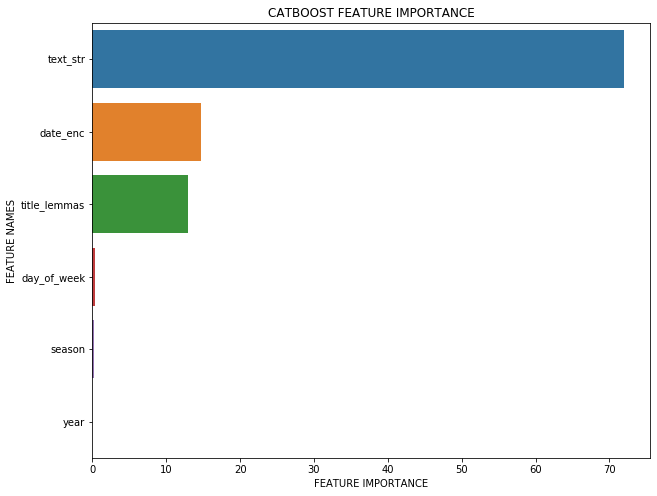

In [38]:
f1 = f1_score(ytest, y_pred1, average='micro')
print(f'F1-score by Catboost (1600 trees, trees depth - 9) is {f1}')

#plot the catboost result
plot_feature_importance(clf.get_feature_importance(),
                        ['text_str', 'title_lemmas', 'date_enc', 'year', 'season', 'day_of_week'],
                        'CATBOOST ')

In [40]:
data_ct1600_9_50_gpu = [f1, '50%', '50%', 1600, 9, *list(clf.get_feature_importance())]

metrics.loc[len(metrics)] = data_ct1600_9_50_gpu
metrics.index = ['Catboost cpu', 'Catboost gpu v01', 'Catboost gpu v01', 'Catboost gpu v02', 'Catboost gpu v03']
metrics

,F1 score,train size,predict size,num of trees,depth,text_str,title_lemmas,date_enc,year,season,day_of_week
Catboost cpu,0.808503,90%,10%,1000,5,58.817622,2.362638,38.530640,0.000000,0.000000,0.289100
Catboost gpu v01,0.879524,55%,45%,1600,9,72.559684,12.846796,14.215693,0.026728,0.113239,0.237861
Catboost gpu v01,0.879178,55%,10%,1600,9,72.559684,12.846796,14.215693,0.026728,0.113239,0.237861
Catboost gpu v02,0.880532,55%,45%,2000,9,71.184946,13.146714,15.146007,0.146486,0.098189,0.277657
Catboost gpu v03,0.877977,50%,50%,1600,9,71.959622,12.941140,14.654882,0.000000,0.152563,0.291793


**Выводы**:
1. Что же критичнее для качества: уменьшить размер выборки в 2 раза или ухудшить гиперы?  
 На наших данных большое значение играли гиперпараметры. Таким образом, лучше уменьшить размер выборки, но оставить оптимальные гиперпараметры. Этот вывод хорошо виден при сравнении f1-score моделей `cpu: 0.808503` - `gpu: 0.879178`. Данные скоры считались на одних и тех же данных.
 
 
2. Если сравнивать модели, обученные на gpu, то, во-первых, увеличение кол-ва деревьев дает прирост к скору, однако не такой большой: `trees=1600: 0.879524` - `trees=2000: 0.880532`.   
Наилучшее кол-во деревьев около 3000, однако прирост в качестве настолько невелик, а время на обучение в разы возрастает, поэтому было решено использовать меньшее кол-во деревьев.


3. Если сравнивать модели, обученные на gpu, то, во-вторых, увеличение выборки не так сильно сказывается на качестве. Модель, обученная на 50% выборки, и модель, обученная на 55% выборки, имеют примерно одинаковые f1-score: `train=55%: 0.879524` - `train=50%: 0.877977`

4. Что касается важности признаков, то мы видим примерно одинаковую картину для моделей, обученных на gpu и отноительно другую на модели, обученной на cpu.  
Занимательно то, что в модели, обученной на cpu, важность текстов новостей всего 58%, а закодированной даты 38%.